## Notebook to compare final results MELD graph vs MELD per vertex
Results on test cohort and independant sites

In [1]:
#imports
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('/home/co-ripa1/rds/hpc-work/scripts/meld_classifier')
from meld_classifier.meld_cohort import MeldSubject,MeldCohort
from meld_graph.training import tp_fp_fn_tn, dice_coeff
from meld_graph.icospheres import IcoSpheres
from meld_graph.graph_tools import GraphTools
import itertools
import pandas as pd
from meld_graph.evaluation import load_prediction
from meld_graph import experiment

Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350


### load per-vertex results

In [2]:
#dataset one of ['test','indi_test']
dataset = 'indi_test'
#for H101 boundaries
cohort2= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_fastsurfer_harmonised_NewSite.hdf5', 
                           dataset='MELD_dataset_NewSiteH27H28H101_nc.csv')

In [3]:
def load_cohort_mlp(dataset):
    # Load the MELD cohort
    if dataset == 'test':
        ref = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-15/ensemble_21-09-15/fold_all/results'
        with h5py.File(os.path.join(ref, 'predictions_ensemble_iteration.hdf5'), "r") as f:
            subjects = list(f.keys())
        subjects.remove('MELD_H4_3T_FCD_0011') # because does not exist in graph model
        cohort = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
                dataset='MELD_dataset_V6.csv')
    elif dataset == 'indi_test':
        refh27h28 = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/predict_NewSiteH27H28_21-09-20/fold_all/results'
        refh101 = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/predict_NewSiteH101_24-02-20/results'
        with h5py.File(os.path.join(refh27h28, 'predictions_ensemble_iteration.hdf5'), "r") as f:
            subjects = list(f.keys())
        with h5py.File(os.path.join(refh101, 'predictions_ensemble_iteration.hdf5'), "r") as f:
            subjects = subjects + list(f.keys())
        cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6_kernels_robustCombat_NewSite.hdf5', dataset='MELD_dataset_NewSiteH27H28H101.csv')
    else:
        raise ValueError('Unknown dataset')
    return cohort, subjects

In [4]:
cohort, subjects =  load_cohort_mlp(dataset)
refh27h28 = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/predict_NewSiteH27H28_21-09-20/fold_all/results'
refh101 = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/predict_NewSiteH101_24-02-20/results'
ref = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-15/ensemble_21-09-15/fold_all/results'


In [5]:
#load the predictions
df_old=pd.DataFrame()
subjects_dictionary={}
#values becomes each row of the dataframe
values={}
for si,subj in enumerate(subjects):
    if si%100==0:
        print(si)
    values['ID']=subj
    #load the subject
    if "H101" in subj:
        s = MeldSubject(subj,cohort=cohort2)
    else:
        s = MeldSubject(subj,cohort=cohort)
    #add the group
    values['group']= True if s.group=='patient' else False
    labels_hemis = {}
    dists={}
    labels = np.zeros(len(cohort.cortex_label)*2)
    #load the borderzone
    for hemi in ['lh','rh']:
        dists[hemi], labels_hemis[hemi] = s.load_feature_lesion_data(
                    features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
                )
        if np.sum(dists[hemi])==0:
            dists[hemi] +=200
    labels = np.hstack([labels_hemis['lh'][cohort.cortex_mask],labels_hemis['rh'][cohort.cortex_mask]])
    borderzones = np.vstack([dists['lh'][cohort.cortex_mask,:],dists['rh'][cohort.cortex_mask,:]]).ravel()<20
    #load pred from old classifier
    if 'H101' in subj:
        pred_file_old = os.path.join(refh101, 'predictions_ensemble_iteration.hdf5')
    elif ('H27' in subj) or ('H28' in subj):
        pred_file_old = os.path.join(refh27h28, 'predictions_ensemble_iteration.hdf5')
    else:
        pred_file_old = os.path.join(ref, 'predictions_ensemble_iteration.hdf5')

    result_hemis_old = load_prediction(subj,pred_file_old, dset='prediction')
    result_old = np.hstack([result_hemis_old['lh'],result_hemis_old['rh']])
    values['model']='per vertex'
    
    #add detection with borderzone
    if labels.sum()>0:
        values['detected'] = np.logical_and(result_old, borderzones).any()
        # add number of TP clusters - number of clusters that are in the borderzone
        clusters_in_borderzone = set(result_old[borderzones.astype('bool')])
        #remove the 0 cluster
        if 0 in clusters_in_borderzone:
            clusters_in_borderzone.remove(0)
        values['number TP clusters'] = len(clusters_in_borderzone)
        values['size_pred'] = len(result_old[borderzones.astype('bool')])
    else:
        values['number TP clusters'] = 0
    # add number of FP clusters : total clusters - TP clusters
    values['number FP clusters']=len(set(result_hemis_old['lh']))+len(set(result_hemis_old['rh']))-2-values['number TP clusters']
    df_old=pd.concat([df_old,pd.DataFrame([values])])
df_old = df_old.reset_index()
df_old.head()

0
100
200


,index,ID,group,model,number TP clusters,number FP clusters,detected,size_pred
0,0,MELD_H27_3T_C_0018,False,per vertex,0,1,NaN,NaN
1,0,MELD_H27_3T_C_0019,False,per vertex,0,1,NaN,NaN
2,0,MELD_H27_3T_C_0020,False,per vertex,0,0,NaN,NaN
3,0,MELD_H27_3T_C_0021,False,per vertex,0,5,NaN,NaN
4,0,MELD_H27_3T_C_0022,False,per vertex,0,0,NaN,NaN


In [6]:
def df_stats(df):
    sensitivity = np.mean(df['detected'][df['group']])
    specificity = (df['number FP clusters'][df['group']==0]==0).mean()
    total_detected = np.sum(df['number TP clusters'][df['group']])
    total_predicted = np.sum(df['number FP clusters'][df['group']])
    ppv = total_detected / (total_predicted + total_detected)
    return np.round(sensitivity,2),np.round(specificity,2),np.round(ppv,2)

# bootstrapped confidence intervals
def bootstrap_CI(df, n=10000, func=df_stats):
    """Calculate confidence intervals for a given function"""
    bootstrapped = []
    for i in range(n):
        bootstrapped.append(func(df.sample(len(df), replace=True)))
    return np.percentile(np.array(bootstrapped), [2.5, 97.5],axis=0)

In [7]:
print('all together')
dfsub = df_old.copy()
dfsub_mlp = dfsub.copy()
sensitivity, specificity, ppv = df_stats(dfsub)
print(sensitivity,specificity,ppv)
print(bootstrap_CI(dfsub))
try:
    for site in ['H27', 'H28', 'H101']:
        print(site)
        dfsub = df_old[df_old['ID'].str.contains(site)]
        sensitivity, specificity, ppv = df_stats(dfsub)
        print(sensitivity,specificity,ppv)
except:
    pass


all together
0.77 0.47 0.46
[[0.69 0.37 0.4 ]
 [0.84 0.56 0.53]]
H27
0.94 0.17 0.52
H28
0.62 nan 0.32
H101
0.76 0.53 0.49


### load results for meld graph model

In [8]:
def load_cohort_graph(dataset,model,no_combat=False):

    # Load the MELD cohort
    nc = ''
    if no_combat:
        nc = '_nc'
    if dataset == 'test':
        experiment_dir = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350'
        
        pred_file = os.path.join(experiment_dir,model,'s_0','fold_all','results_best_model', 'predictions.hdf5')
        cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6_kernels_noCombat.hdf5',
                            dataset='MELD_dataset_v6.csv')
    elif dataset == 'indi_test':
        experiment_dir = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350'
        pred_file = os.path.join(experiment_dir,model,'s_0','fold_all',
                                  'test_H27H28H101{}'.format(nc),'results_best_model', 'predictions.hdf5')
        cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6_kernels_robustCombat_NewSite.hdf5', 
                           dataset='MELD_dataset_NewSiteH27H28H101{}.csv'.format(nc))
            
    else:
        raise ValueError('Unknown dataset')
    with h5py.File(pred_file, "r") as f:
        subjects = list(f.keys())
    return cohort, subjects,pred_file

In [13]:
#  #for test dataset
model = '23-10-30_LVHZ_dcp'
#model='23-10-30_MSBS_dcop_with_combat'
# # model ='24-01-04_best_dcop_with_combat'

cohort, subjects, pred_file = load_cohort_graph(dataset,model,
no_combat=False)

In [14]:
df=pd.DataFrame()
subjects_dictionary={}
values={}
for si,subj in enumerate(subjects):
    if si%100==0:
        print(si)
    values['ID']=subj
    if "H101" in subj:
        s = MeldSubject(subj,cohort=cohort2)
    else:
        s = MeldSubject(subj,cohort=cohort)
    values['group']= True if s.group=='patient' else False
    labels_hemis = {}
    dists={}
    labels = np.zeros(len(cohort.cortex_label)*2)
    for hemi in ['lh','rh']:
        dists[hemi], labels_hemis[hemi] = s.load_feature_lesion_data(
                    features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
                )
        if np.sum(dists[hemi])==0:
            dists[hemi] +=200
    labels = np.hstack([labels_hemis['lh'][cohort.cortex_mask],labels_hemis['rh'][cohort.cortex_mask]])
    borderzones = np.vstack([dists['lh'][cohort.cortex_mask,:],dists['rh'][cohort.cortex_mask,:]]).ravel()<20
    #load pred from graph classifier

    result_hemis = load_prediction(subj,pred_file, dset='prediction_clustered')
    result = np.hstack([result_hemis['lh'],result_hemis['rh']])
    values['model']='graph'
    
    #add detection with borderzone
    if labels.sum()>0:
        values['detected'] = np.logical_and(result, borderzones).any()
        clusters_in_borderzone = set(result[borderzones.astype('bool')])
        #remove the 0 cluster
        if 0 in clusters_in_borderzone:
            clusters_in_borderzone.remove(0)
        values['number TP clusters'] = len(clusters_in_borderzone)
        values['size_pred'] = len(result[borderzones.astype('bool')])
    else:
        values['number TP clusters'] = 0
    # add number of FP clusters : total clusters - TP clusters
    values['number FP clusters']=len(set(result_hemis['lh']))+len(set(result_hemis['rh']))-2-values['number TP clusters']
    df=pd.concat([df,pd.DataFrame([values])])
    
    
df = df.reset_index()
df.head()

0
100
200


,index,ID,group,model,number TP clusters,number FP clusters,detected,size_pred
0,0,MELD_H101_3T_C_00002,False,graph,0,0,NaN,NaN
1,0,MELD_H101_3T_C_00005,False,graph,0,1,NaN,NaN
2,0,MELD_H101_3T_C_00008,False,graph,0,1,NaN,NaN
3,0,MELD_H101_3T_C_00011,False,graph,0,0,NaN,NaN
4,0,MELD_H101_3T_C_00012,False,graph,0,2,NaN,NaN


In [15]:
print('all together')
dfsub = df.copy()
sensitivity, specificity, ppv = df_stats(dfsub)

print(sensitivity,specificity,ppv)
print(bootstrap_CI(dfsub))
try:
    for site in ['H27', 'H28', 'H101']:
        print(site)
        dfsub = df[df['ID'].str.contains(site)]
        sensitivity, specificity, ppv = df_stats(dfsub)
        print(sensitivity,specificity,ppv)
except:
    pass

all together
0.73 0.56 0.77
[[0.65 0.46 0.7 ]
 [0.81 0.66 0.84]]
H27
0.82 0.44 0.74
H28
0.69 nan 0.61
H101
0.72 0.59 0.81


In [112]:
dfsub = df[df['ID'].str.contains('H101')]
sensitivity, specificity, ppv = df_stats(dfsub)
sensitivity

/tmp/ipykernel_238123/17189270.py:6: RuntimeWarning: invalid value encountered in long_scalars
  ppv = total_detected / (total_predicted + total_detected)


nan

In [16]:
# Compare models with permutation
def permute_models(df):
    for index, row in df.iterrows():
        # Randomly permute the data from column 0 and 1
        permuted_indices = np.random.permutation(2)
        if (permuted_indices == [1,0]).all():
            df.at[index, 'detected_MLP'], df.at[index, 'detected_Graph'] = \
            row[['detected_MLP', 'detected_Graph']].values[permuted_indices]
            df.at[index, 'number TP clusters_MLP'], df.at[index, 'number TP clusters_Graph'] = \
            row[['number TP clusters_MLP', 'number TP clusters_Graph']].values[permuted_indices]
            df.at[index, 'number FP clusters_MLP'], df.at[index, 'number FP clusters_Graph'] = \
            row[['number FP clusters_MLP', 'number FP clusters_Graph']].values[permuted_indices]
    return df

df_mlp = df_old.copy()
sensitivity_mlp_orig, specificity_mlp_orig, ppv_mlp_orig = df_stats(df_mlp)
print(sensitivity_mlp_orig, specificity_mlp_orig, ppv_mlp_orig)
df_graph = df.copy()
sensitivity_graph_orig, specificity_graph_orig, ppv_graph_orig = df_stats(df_graph)
print(sensitivity_graph_orig, specificity_graph_orig, ppv_graph_orig)
#compute difference
diff_sensitivity_orig = sensitivity_mlp_orig - sensitivity_graph_orig
diff_specificity_orig = specificity_mlp_orig - specificity_graph_orig
diff_ppv_orig = ppv_mlp_orig - ppv_graph_orig

#combine results for MLP and Graph 
df_comp = df_mlp[['ID','group','detected','number TP clusters','number FP clusters']].merge(df_graph[['ID','group','detected','number TP clusters','number FP clusters']], how='left', on=['ID','group'], suffixes=['_MLP','_Graph'])

diffs_sensitivity = []
diffs_specificity = []
diffs_ppv = []
for i in range(0,1000):
    # shuffle models
    df_shuffle = permute_models(df_comp.copy())
    
    # compute metrics again
    df_shuffle_mlp = pd.DataFrame()
    df_shuffle_mlp[['group','detected','number TP clusters','number FP clusters']] = df_shuffle[['group','detected_MLP','number TP clusters_MLP','number FP clusters_MLP']].copy()
    sensitivity_mlp, specificity_mlp, ppv_mlp = df_stats(df_shuffle_mlp)
    # print(sensitivity_mlp,specificity_mlp, ppv_mlp)
    
    df_shuffle_graph = pd.DataFrame()
    df_shuffle_graph[['group','detected','number TP clusters','number FP clusters']] = df_shuffle[['group','detected_Graph','number TP clusters_Graph','number FP clusters_Graph']].copy()
    sensitivity_graph, specificity_graph, ppv_graph = df_stats(df_shuffle_graph)
    # print(sensitivity_graph,specificity_graph, ppv_graph)
    
    # find differences
    diffs_sensitivity.append(sensitivity_mlp - sensitivity_graph)
    diffs_specificity.append(specificity_mlp - specificity_graph)
    diffs_ppv.append(ppv_mlp - ppv_graph)


0.77 0.47 0.46
0.73 0.56 0.77


In [10]:
def get_pvalue(stat, distribution):
    p_pos = np.mean(distribution > stat)
    p_neg = np.mean(distribution < stat)
    p = min(p_pos,p_neg)*2
    return p

0.192 0.042 0.0


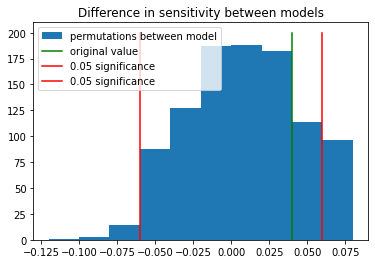

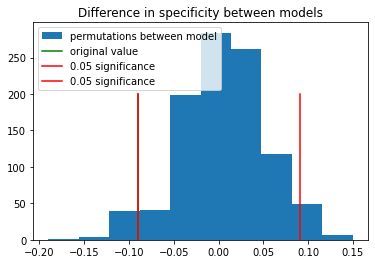

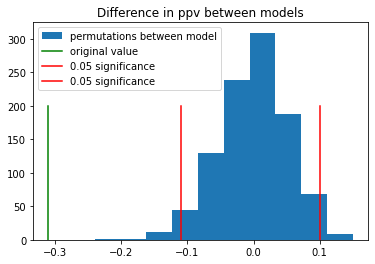

In [18]:
#compute pvalue
p_sensitivity = get_pvalue(diff_sensitivity_orig, diffs_sensitivity)
p_specificity = get_pvalue(diff_specificity_orig, diffs_specificity)
p_ppv = get_pvalue(diff_ppv_orig, diffs_ppv)
print(p_sensitivity, p_specificity, p_ppv)


#plot results shuffle
plt.figure()
plt.hist(diffs_sensitivity, label='permutations between model')
#add results orig
plt.plot([diff_sensitivity_orig,diff_sensitivity_orig], [0,200], label='original value', color='green')
#add 5% significance lines
lines5 = np.percentile(diffs_sensitivity, [2.5, 97.5])
plt.plot([lines5[0],lines5[0]], [0,200], label='0.05 significance', color='red')
plt.plot([lines5[1],lines5[1]], [0,200], label='0.05 significance', color='red')
plt.title('Difference in sensitivity between models')
plt.legend()

plt.figure()
plt.hist(diffs_specificity, label='permutations between model')
#add results orig
plt.plot([diff_specificity_orig,diff_specificity_orig], [0,200], label='original value', color='green')
#add 5% significance lines
lines5 = np.percentile(diffs_specificity, [2.5, 97.5])
plt.plot([lines5[0],lines5[0]], [0,200], label='0.05 significance', color='red')
plt.plot([lines5[1],lines5[1]], [0,200], label='0.05 significance', color='red')
plt.title('Difference in specificity between models')
plt.legend()

plt.figure()
plt.hist(diffs_ppv, label='permutations between model')
#add results orig
plt.plot([diff_ppv_orig,diff_ppv_orig], [0,200], label='original value', color='green')
#add 5% significance lines
lines5 = np.percentile(diffs_ppv, [2.5, 97.5])
plt.plot([lines5[0],lines5[0]], [0,200], label='0.05 significance', color='red')
plt.plot([lines5[1],lines5[1]], [0,200], label='0.05 significance', color='red')
plt.title('Difference in ppv between models')
plt.legend()


In [24]:
#number clusters

print('MLP')
for quantile in [.5,.25,.75,1]:
    print(quantile,dfsub_mlp.groupby('group').quantile(quantile)['number FP clusters'])


print('MELD graph')
for quantile in [.5,.25,.75,1]:
    print(quantile,df.groupby('group').quantile(quantile)['number FP clusters'])



MLP
0.5 group
False    1.0
True     1.0
Name: number FP clusters, dtype: float64
0.25 group
False    0.0
True     0.0
Name: number FP clusters, dtype: float64
0.75 group
False    1.0
True     2.0
Name: number FP clusters, dtype: float64
1 group
False    16.0
True      7.0
Name: number FP clusters, dtype: float64
MELD graph
0.5 group
False    1.0
True     0.0
Name: number FP clusters, dtype: float64
0.25 group
False    1.0
True     0.0
Name: number FP clusters, dtype: float64
0.75 group
False    1.0
True     0.0
Name: number FP clusters, dtype: float64
1 group
False    2.0
True     5.0
Name: number FP clusters, dtype: float64


/tmp/ipykernel_19331/2028796310.py:5: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  print(quantile,dfsub_mlp.groupby('group').quantile(quantile)['number FP clusters'])
/tmp/ipykernel_19331/2028796310.py:5: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  print(quantile,dfsub_mlp.groupby('group').quantile(quantile)['number FP clusters'])
/tmp/ipykernel_19331/2028796310.py:5: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  print(quantile,dfsub_mlp.groupby('group').quantile(quan

### add breakdown on test dataset

In [61]:
# for test dataset
experiment_dir = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350'
model = '23-10-30_LVHZ_dcp'
df_model = pd.read_csv(os.path.join(experiment_dir,model,
                                          's_0','fold_all','results_best_model','test_results.csv'))

cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6_kernels.hdf5', dataset='MELD_dataset_NewSiteH27H28H101.csv')


In [62]:
# add demographic
age_array=[]
sex_array=[]
histo_array=[]
site_array=[]
scanner_array=[]
flair_array=[]
group_array=[]
sf_array=[]
mri_negative_array=[]
surgery_array=[]
for subject in df_model['ID']:
    subj = MeldSubject(subject, cohort)
    age, sex, histo, site, sf, mri_negative, surgery = subj.get_demographic_features(["Age at preoperative", "Sex", "Histology", "Site", "Seizure free", "Ever reported MRI negative", "Surgery"])
    scanner_array.append(subj.scanner)
    age_array.append(age)
    sex_array.append(sex)
    histo_array.append(histo)
    site_array.append(site)
    sf_array.append(sf)
    flair_array.append(subj.has_flair)
    mri_negative_array.append(mri_negative)
    surgery_array.append(surgery)

    
df_model['Age at preoperative']=age_array
df_model['Sex']=sex_array
df_model['Histology']=histo_array
df_model['Site']=site_array
df_model['Scanner']=scanner_array
df_model['FLAIR']=flair_array
df_model['Seizure free']=sf_array
df_model['Ever reported MRI negative'] = mri_negative_array
df_model['Operated'] = surgery_array

df_model.head()

,ID,group,detected,number FP clusters,number TP clusters,tp,fp,fn,tn,dice lesional,dice non-lesional,Age at preoperative,Sex,Histology,Site,Scanner,FLAIR,Seizure free,Ever reported MRI negative,Operated
0,MELD_H2_15T_FCD_0001,True,False,0,0,0,0,271,293533,3.690037e-18,0.999539,20.0,1.0,NaN,H2,15T,False,1.0,0.0,1.0
1,MELD_H2_15T_FCD_0003,True,True,1,1,3826,24434,74,265470,2.379353e-01,0.955877,10.0,0.0,NaN,H2,15T,False,NaN,0.0,0.0
2,MELD_H2_15T_FCD_0005,True,False,2,0,0,20027,262,273515,4.928779e-20,0.964237,20.0,1.0,NaN,H2,15T,False,NaN,0.0,0.0
3,MELD_H2_15T_FCD_0007,True,True,0,1,2058,3928,205,287613,4.989696e-01,0.992866,4.0,1.0,FCD_2B,H2,15T,False,1.0,0.0,1.0
4,MELD_H2_15T_FCD_0008,True,True,0,1,103,52023,867,240811,3.879765e-03,0.901050,10.0,1.0,NaN,H2,15T,False,NaN,0.0,0.0


In [76]:
pat = df_model[df_model['group']==True].copy()

In [43]:
def compute_pval(df_var,diff_orig, var='Seizure free'):
    diffs = []
    for i in range(0,1000):
        df_shuffle = df_var.copy()
        np.random.shuffle(df_shuffle[var].values)
        disp_df_shuffle=pd.DataFrame(100*df_shuffle.groupby([var]).mean()['detected']).round(1)
        diffs.append(disp_df_shuffle['detected'].values[1]-disp_df_shuffle['detected'].values[0])

    pval = get_pvalue(diff_orig, diffs)
    print(pval)
    
    #plot results shuffle
    plt.figure()
    plt.hist(diffs, label='permutations between group')
    #add results orig
    plt.plot([diff_orig,diff_orig], [0,200], label='original value', color='green')
    #add 5% significance lines
    lines5 = np.percentile(diffs, [2.5, 97.5])
    plt.plot([lines5[0],lines5[0]], [0,200], label='0.05 significance', color='red')
    plt.plot([lines5[1],lines5[1]], [0,200], label='0.05 significance', color='red')
    plt.title(f'Difference between group {var}')
    plt.legend()
    
    return pval

In [44]:
disp_df=pd.DataFrame(100*pat.groupby('Scanner').mean()['detected']).round(1)
disp_df['count'] = pat.groupby('Scanner').count()['detected']
disp_df

,detected,count
Scanner,,
15T,62.5,56
3T,72.5,204


In [45]:
disp_df=pd.DataFrame(100*pat.groupby(['Scanner','FLAIR']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['Scanner','FLAIR']).count()['detected']
disp_df

detected  count
Scanner FLAIR                 
15T     False      58.3     36
        True       70.0     20
3T      False      71.9    114
        True       73.3     90

In [12]:
disp_df=pd.DataFrame(100*pat.groupby(['FLAIR']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['FLAIR']).count()['detected']
disp_df

# #get difference and pval
# diff_orig = disp_df['detected'].values[0]-disp_df['detected'].values[1]
# var='FLAIR'
# pval= compute_pval(pat[['detected',var]], diff_orig, var=var)
# print(diff_orig, pval)


,detected,count
FLAIR,,
False,68.7,150
True,72.7,110


              detected  count
Seizure free                 
0.0               64.7     51
1.0               79.2    106
0.056
-14.5 0.056


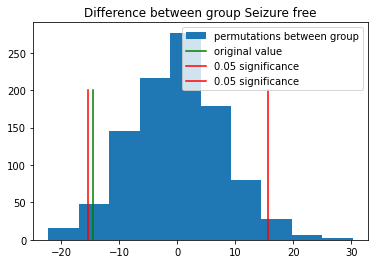

In [26]:
disp_df=pd.DataFrame(100*pat.groupby(['Seizure free']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['Seizure free']).count()['detected']
print(disp_df)

#get difference and pval
diff_orig = disp_df['detected'].values[0]-disp_df['detected'].values[1]
var='Seizure free'
pval= compute_pval(pat[['detected',var]], diff_orig, var=var)
print(diff_orig, pval)


     detected  count
Sex                 
0.0      64.0    125
1.0      76.3    135
0.05
-12.299999999999997 0.05


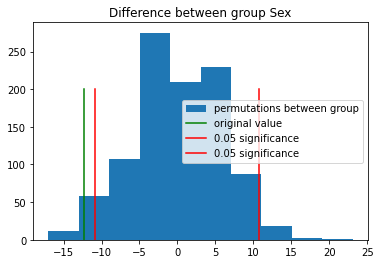

In [27]:
disp_df=pd.DataFrame(100*pat.groupby(['Sex']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['Sex']).count()['detected']
print(disp_df)

#get difference and pval
diff_orig = disp_df['detected'].values[0]-disp_df['detected'].values[1]
var='Sex'
pval= compute_pval(pat[['detected',var]], diff_orig, var=var)
print(diff_orig, pval)

In [78]:
pat['Operated'] = pat['Operated'].fillna(666)
pat['Histology'] = pat['Histology'].fillna('not available')
pat.loc[(pat['Histology']=='not available')&(pat['Operated']==0), 'Histology'] = 'not operated'
disp_df=pd.DataFrame(100*pat.groupby(['Histology']).mean()['detected']).round(1)
disp_df['n patients'] = pat.groupby(['Histology']).count()['detected']
print(disp_df.rename(columns={'detected':'% Detected'}))

#get difference and pval
var='Histology'
histos = ['FCD_1', 'FCD_2A', 'FCD_2B', 'FCD_3', 'not available', 'not operated']
diff_orig_histos = np.zeros(len(histos))
for h,histo in enumerate(histos):
    diff_orig_histos[h]=disp_df['detected'].values[h]

diffs_histos = np.zeros((len(histos), 1000))
for i in range(0,1000):
    df_shuffle = pat[['detected',var]].copy()
    np.random.shuffle(df_shuffle[var].values)
    for h,histo in enumerate(histos):
        disp_df_shuffle=pd.DataFrame(100*df_shuffle.groupby([var]).mean()['detected']).round(1)
        diffs_histos[h,i] = disp_df_shuffle['detected'].values[h]
pvals_histos= np.zeros(len(histos))
for h,histo in enumerate(histos):
    pval = get_pvalue(diff_orig_histos[h], diffs_histos[h,:])
    print(histo)
    print(pval)
    pvals_histos[h]=pval
    
import statsmodels.stats.multitest as multi
pvals_histos_cor = multi.multipletests(pvals_histos.flatten(), alpha=0.05, method='holm')[1]
print(pvals_histos_cor)

               % Detected  n patients
Histology                            
FCD_1                84.6          13
FCD_2A               75.4          57
FCD_2B               76.3          93
FCD_3                75.0           8
not available        52.2          23
not operated         60.6          66
FCD_1
0.14
FCD_2A
0.292
FCD_2B
0.094
FCD_3
0.486
not available
0.038
not operated
0.034
[0.42  0.584 0.376 0.584 0.204 0.204]


                            detected  count
Ever reported MRI negative                 
0.0                             72.8    180
1.0                             65.0     80
0.226
7.799999999999997 0.226


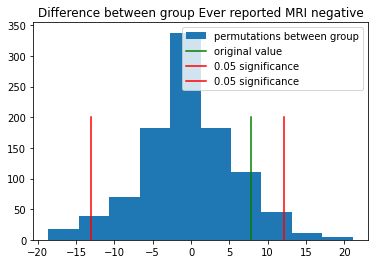

In [28]:
disp_df=pd.DataFrame(100*pat.groupby(['Ever reported MRI negative']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['Ever reported MRI negative']).count()['detected']
print(disp_df)

#get difference and pval
diff_orig = disp_df['detected'].values[0]-disp_df['detected'].values[1]
var='Ever reported MRI negative'
pval= compute_pval(pat[['detected',var]], diff_orig, var=var)
print(diff_orig, pval)

/tmp/ipykernel_27801/4152983771.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pat['paediatric'] = pat['Age at preoperative']<18


            detected  count
paediatric                 
False           69.5    131
True            71.3    129
0.712
-1.7999999999999972 0.712


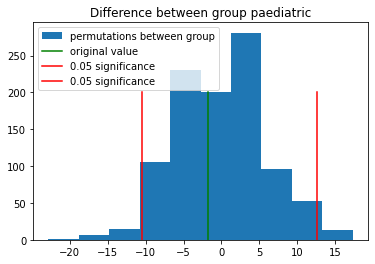

In [29]:
pat['paediatric'] = pat['Age at preoperative']<18
disp_df=pd.DataFrame(100*pat.groupby(['paediatric']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['paediatric']).count()['detected']
print(disp_df)

#get difference and pval
diff_orig = disp_df['detected'].values[0]-disp_df['detected'].values[1]
var='paediatric'
pval= compute_pval(pat[['detected',var]], diff_orig, var=var)
print(diff_orig, pval)

In [29]:
pat['Histology'] = pat['Histology'].fillna('not available')
pat['Histology']= pat['Histology']=='not available'
disp_df=pd.DataFrame(100*pat.groupby(['Histology']).mean()['detected']).round(1)
disp_df['n patients'] = pat.groupby(['Histology']).count()['detected']
disp_df.rename(columns={'detected':'% Detected'})

/tmp/ipykernel_278813/3171424778.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pat['Histology'] = pat['Histology'].fillna('not available')
/tmp/ipykernel_278813/3171424778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pat['Histology']= pat['Histology']=='not available'


,% Detected,n patients
Histology,,
False,76.6,171
True,58.4,89
